
Data Loaded: (82332, 45)
   id       dur proto service state  spkts  dpkts  sbytes  dbytes  \
0   1  0.000011   udp       -   INT      2      0     496       0   
1   2  0.000008   udp       -   INT      2      0    1762       0   
2   3  0.000005   udp       -   INT      2      0    1068       0   
3   4  0.000006   udp       -   INT      2      0     900       0   
4   5  0.000010   udp       -   INT      2      0    2126       0   

          rate  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
0   90909.0902  ...                 1               2             0   
1  125000.0003  ...                 1               2             0   
2  200000.0051  ...                 1               3             0   
3  166666.6608  ...                 1               3             0   
4  100000.0025  ...                 1               3             0   

   ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  \
0           0                 0           1           2 

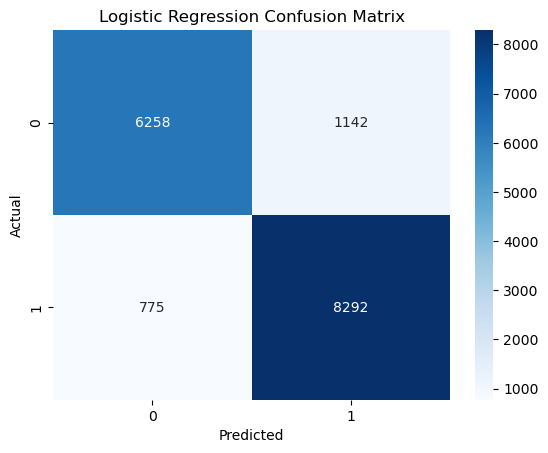


-
Running Naive Bayes...
-

Naive Bayes Metrics:
 {'Accuracy': 0.7707536284690594, 'F1': 0.7794590173511714, 'AUC': 0.8550482966146913}


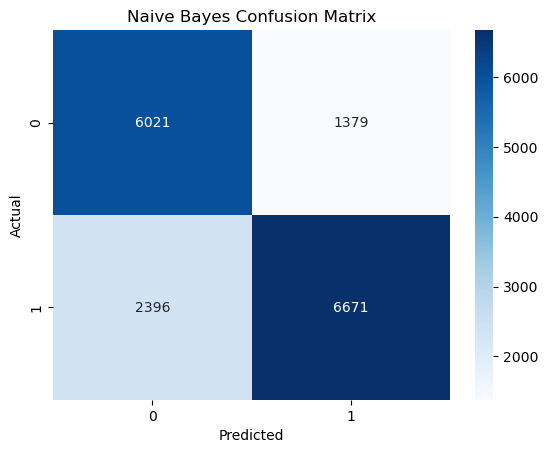


-
Running KNN...
-

KNN Metrics:
 {'Accuracy': 0.926641161110099, 'F1': 0.9315890814361762, 'AUC': 0.9797970662843278}


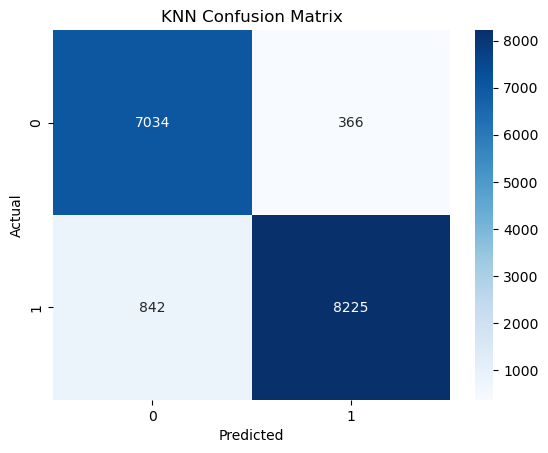



- Summary of Model Results -
                     Accuracy      F1     AUC
Logistic Regression    0.8836  0.8964  0.9609
Naive Bayes            0.7708  0.7795  0.8550
KNN                    0.9266  0.9316  0.9798


<Figure size 1000x600 with 0 Axes>

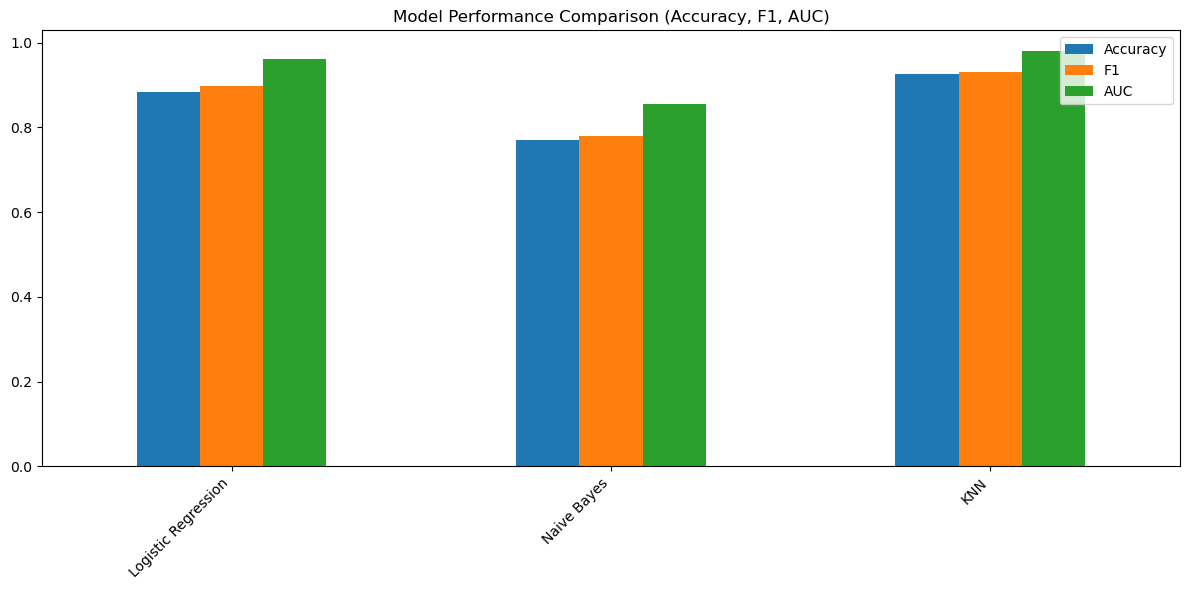

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

def metrics(y_true, y_pred, y_prob=None):
    """Return Accuracy, F1, and AUC metrics."""
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "AUC": roc_auc_score(y_true, y_prob if y_prob is not None else y_pred)
    }

def plot_confusion(y_true, y_pred, title):
    """Plot confusion matrix for model results."""
    plt.figure()
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"{title} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    """Fit model, predict, and evaluate metrics."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    result = metrics(y_test, y_pred, y_prob)
    print(f"\n{name} Metrics:\n", result)
    plot_confusion(y_test, y_pred, name)
    return result

RANDOM_STATE = 42
df = pd.read_csv("UNSW_NB15_training-set.csv")

print("\nData Loaded:", df.shape)
print(df.head())

drop_cols = ['id', 'proto', 'service', 'state']
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

df = df.replace([np.inf, -np.inf], np.nan).dropna()

target_col = "label"
if target_col not in df.columns:
    raise ValueError("Expected 'label' column not found!")

y = df[target_col].values
X = df.drop(columns=['label', 'attack_cat'], errors='ignore')

cat_cols = X.select_dtypes(include=["object"]).columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

X = X.fillna(X.median(numeric_only=True))
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='lbfgs', n_jobs=-1),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
}

results = {}
for name, model in models.items():
    print(f"\n{'-'}\nRunning {name}...\n{'-'}")
    results[name] = evaluate_model(name, model, X_train, X_test, y_train, y_test)

print("\n\n- Summary of Model Results -")
summary_df = pd.DataFrame(results).T
print(summary_df.round(4))

plt.figure(figsize=(10, 6))
summary_df.plot(kind="bar", figsize=(12, 6))
plt.title("Model Performance Comparison (Accuracy, F1, AUC)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()